In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy
from analyses.calc_noise_ceilings import RSA_NOISE_CEILING_DIR, load_mean_std
from notebook_utils import load_results_data, add_avg_subject

In [139]:
CAPTION = "caption"
IMAGE = "image"
PREDS = "predictions"
TARGETS = "latents"
STIM_TYPES = "stimulus_types"

MOD_SPECIFIC_IMGS = "train_images"
MOD_SPECIFIC_CAPS = "train_captions"

def load_results_files(model="*", features="*", mode="*", subject="*"):
    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    files_regex = f"{results_root_dir}/{mode}/{subject}/{model}_{features}_best_val_acc/results.p"
    result_files = sorted(glob(files_regex))
    return [pickle.load(open(file, 'rb')) for file in result_files]

def calc_zero_shot_score(model, train_features, test_features, train_mode, test_mode, test_modality):
    acc_scores = []
    results_all_subjects_train = load_results_files(model, train_features, train_mode)
    results_all_subjects_test = load_results_files(model, test_features, test_mode)
    assert len(results_all_subjects_train) == len(results_all_subjects_test)
    print(f"loaded results from {len(results_all_subjects_train)} subjects")
    for results_train, results_test in zip(results_all_subjects_train, results_all_subjects_test):
        preds = results_train[PREDS][results_train[STIM_TYPES] == test_modality]
        
        targets = results_test[TARGETS][results_test[STIM_TYPES] == test_modality]
        assert len(preds) == NUM_TEST_STIMULI / 2
        acc = pairwise_accuracy(targets, preds)
        acc_scores.append(acc)

    return acc_scores

def calc_zero_shot_scores(models):
    results = []
    for model in models:
                    
        scores_img_cap = calc_zero_shot_score(model, "vision", "lang", MOD_SPECIFIC_IMGS, MOD_SPECIFIC_CAPS, CAPTION)
        for score in scores_img_cap:
            results.append({
                "model": model,
                "features": "vision",
                "metric": "zero_shot_img_cap",
                "value": score,
            })
        scores_cap_img = calc_zero_shot_score(model, "lang", "vision", MOD_SPECIFIC_CAPS, MOD_SPECIFIC_IMGS, IMAGE)
        for score in scores_cap_img:
            results.append({
                "model": model,
                "features": "lang",
                "metric": "zero_shot_cap_img",
                "value": score,
            })

        scores_img_img = calc_zero_shot_score(model, "vision", "vision", MOD_SPECIFIC_IMGS, MOD_SPECIFIC_IMGS, IMAGE)
        for score in scores_img_img:
            results.append({
                "model": model,
                "features": "vision",
                "metric": "images",
                "value": score,
            })
        scores_cap_cap = calc_zero_shot_score(model, "lang", "lang", MOD_SPECIFIC_CAPS, MOD_SPECIFIC_CAPS, CAPTION)
        for score in scores_cap_cap:
            results.append({
                "model": model,
                "features": "lang",
                "metric": "captions",
                "value": score,
            })

    df = pd.DataFrame(results)
    df["model_feat"] = df.model + "_" + df.features

    return df
    

# models = ["random-flava", "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt", "glow"]
models = ["glow", "glow-contrastive"]

results_table = calc_zero_shot_scores(models)
# results_table

loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects
loaded results from 6 subjects


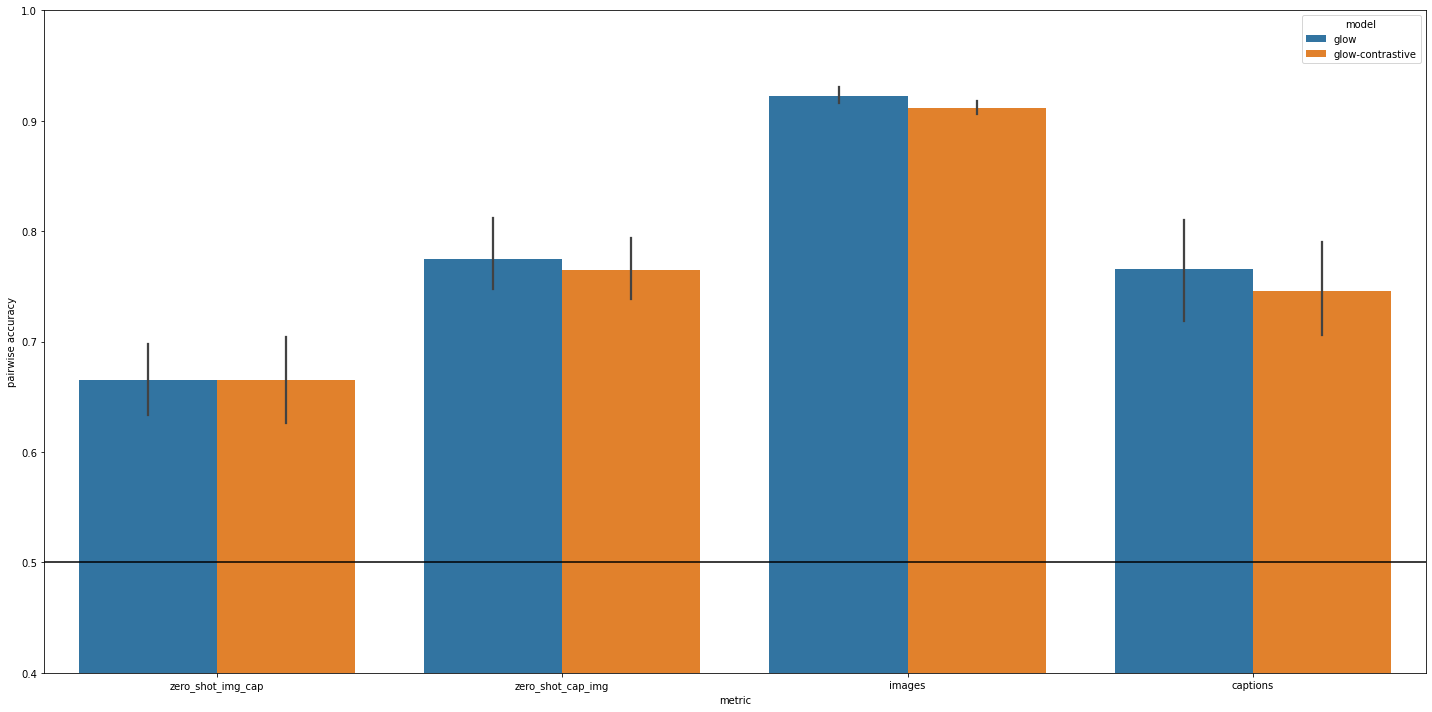

In [140]:
plt.figure(figsize=(20, 10))
sns.barplot(data=results_table, x="metric", y="value", hue="model")
plt.ylim((0.4, 1))
plt.axhline(y=0.5, color="black")
plt.ylabel("pairwise accuracy")
plt.tight_layout()
plt.savefig("glow_zero_shot_cross_modal_decoding.png", dpi=300, facecolor='white', transparent=False)

In [2]:
def calc_alt_rsas():
    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))

        for metric in ["spearmanr", "pearsonr"]:
            for matrix_metric in ["spearmanr", "pearsonr"]:
                rsa = calc_rsa(results['predictions'], results['latents'], metric, matrix_metric)
                results[f"rsa_{metric}_{matrix_metric}"] = rsa

        pickle.dump(results, open(result_file_path, 'wb'))

# def calc_alt_rsas_imgs_captions():
#     results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

#     result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
#     for result_file_path in tqdm(result_files):        
#         results = pickle.load(open(result_file_path, 'rb'))
#         results['rsa_images'] = calc_rsa_images(results['predictions'], results['latents'], results['stimulus_types'])
#         results['rsa_captions'] = calc_rsa_captions(results['predictions'], results['latents'], results['stimulus_types'])

#         pickle.dump(results, open(result_file_path, 'wb'))

# calc_alt_rsas()
# calc_alt_rsas_imgs_captions()

In [3]:
def calc_new_rsa():
    fmri_test_betas = dict()
    for subj in SUBJECTS:
        fmri_test_betas[subj], _, _, _ = get_fmri_data(subj, "test", load_mean_std(subj))

    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))
        betas = fmri_test_betas[results['subject']]
        results['rsa_images'] = calc_rsa_images(betas, results['latents'], results['stimulus_types'])
        results['rsa_captions'] = calc_rsa_captions(betas, results['latents'], results['stimulus_types'])

        pickle.dump(results, open(result_file_path, 'wb'))

# calc_new_rsa()

In [4]:
all_data = load_results_data()

MODEL_ORDER = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt", "resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649.0,pairwise_acc_captions,0.860455,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649.0,pairwise_acc_images,0.884472,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649.0,pairwise_acc_mean,0.872464,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,anatomical_lang,11150.0,pairwise_acc_captions,0.809731,bert-base-uncased_lang
4,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,anatomical_lang,11150.0,pairwise_acc_images,0.797930,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...
20816,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_high_level,11205.0,pairwise_acc_images,0.892340,vit-l-16_vision
20817,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_high_level,11205.0,pairwise_acc_mean,0.801863,vit-l-16_vision
20818,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_low_level,9953.0,pairwise_acc_captions,0.615942,vit-l-16_vision
20819,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_low_level,9953.0,pairwise_acc_images,0.907246,vit-l-16_vision


In [5]:
all_data_avg = add_avg_subject(all_data)
all_data_avg = all_data_avg[all_data_avg.subject == "average"]

In [6]:
# ref performance order:
#['random-flava', 'resnet-152', 'vit-b-16', 'vit-l-16', 'resnet-18', 'resnet-50', 'dino-giant', 'dino-large', 'dino-base', 'bert-large-uncased', 'bert-base-uncased',
# 'llama2-7b', 'mixtral-8x7b', 'mistral-7b', 'llama2-13b', 'gpt2-small', 'gpt2-medium', 'gpt2-xl', 'gpt2-large', 'visualbert', 'bridgetower-large', 'clip', 'flava', 'imagebind', 'lxmert', 'vilt']

def calc_model_feat_order(data):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in ["vision", "lang", "vision+lang"]:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

for model in MODEL_ORDER:
    print(model, end=" ")

random-flava vit-b-16 vit-l-16 resnet-18 resnet-50 resnet-152 dino-base dino-large dino-giant bert-base-uncased bert-large-uncased llama2-7b llama2-13b mistral-7b mixtral-8x7b gpt2-small gpt2-medium gpt2-large gpt2-xl visualbert bridgetower-large clip flava imagebind lxmert vilt resnet-50-glow bge resnet-and-bge glow glow-contrastive 

In [7]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']


In [8]:
def plot_metric(data, kind="bar", x_variable="model_feat", order=None, hue_variable="model_feat", hue_order=None, metric="pairwise_acc_mean", ylim=(0.5, 1), plot_legend=True, palette=None,
                noise_ceiling=None, hatches=None, axis=None, marker="o", markersize=5, legend_title="Model features modality", dodge=False):
    data_filtered = data[data.metric == metric]

    sns.set_style("ticks", {'axes.grid' : True})
    if kind == "bar":
        g = sns.barplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette, err_kws={'linewidth': 0.5}, width=0.95)
    elif kind == "point":
        g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
                          errorbar=None, marker=marker, markersize=markersize, markeredgewidth=1, linestyle="none", ax=axis, dodge=dodge)

    g.legend().remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.legend(loc='upper left', title="", bbox_to_anchor=(0.05, 0.95), ncol=9)
        lgd = g.legend(ncol=3, title=legend_title)
        bbox_extra_artists = (lgd,)

    if noise_ceiling is not None:
        g.axhline(y=noise_ceiling)

    if hatches is not None:
        for i, thisbar in enumerate(g.patches[:len(hatches)]):
            thisbar.set_hatch(hatches[i])

    g.set(ylim=ylim, ylabel=metric, xlabel='')

    # print(g.get_xticklabels())
    # g.set_xticklabels([label.get_text().split('_')[0] for label in g.get_xticklabels()], rotation=80)

    plt.tight_layout()
    
    return g, data_filtered

In [9]:
def get_short_label_text(label, cut_labels=True):
    text = label.get_text().split('_')[0]
    if cut_labels and (len(text) > 10):
        text = f"{'-'.join(text.split('-')[:-1])}-\n{text.split('-')[-1]}"
    return text
    
def plot_metric_catplot(data, kind="bar", x_variable="model_feat", order=None, row_variable="subject", row_order=None, col_variable=None, hue_variable="model_feat", hue_order=None, metrics=["pairwise_acc_mean"], ylim=(0.5, 1),
                        plot_legend=True, palette=None, noise_ceilings=None, hatches=None, legend_title="Model features modality", height=4, aspect=4, legend_bbox=(0.05,1), rotation=80, cut_labels=True):
    data_filtered = data[data.metric.isin(metrics)]

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,
                    palette=palette, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.fig.legend(ncol=2, title=legend_title, loc="upper left", bbox_to_anchor=legend_bbox)#, bbox_to_anchor=(0.02, 0.95), ncol=9)
        bbox_extra_artists = (lgd,)

    for i in range(len(g.axes[-1])):
        last_axis = g.axes[-1][i]
        last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
        
    g.set(ylim=ylim, ylabel="pairwise_acc_mean", xlabel='')
    
    plt.tight_layout()
    
    return g, data_filtered, lgd

## Modality-agnostic decoding vs. modality-specific decoding

In [10]:
FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Legend", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", row_order=None, col_variable=None, legend_bbox=(0.06,1), height=4.5, aspect=4):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]
    data_training_mode_captions = data[data.training_mode == "captions"]
    data_training_mode_images = data[data.training_mode == "images"]

    for m_feat in data_training_mode_full.model_feat.unique():
        length = len(data_training_mode_full[(data_training_mode_full.model_feat == m_feat) & (data_training_mode_full.metric == metrics[0])])
        expected_num_datapoints = len(SUBJECTS)
        if hue_variable != "features":
            expected_num_datapoints *= len(data[hue_variable].unique())
        assert length == expected_num_datapoints, f"too long or short: {length} (expected: {expected_num_datapoints})"

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, legend_bbox=legend_bbox, height=height, aspect=aspect,
                                                  hue_variable=hue_variable, row_variable=row_variable, row_order=row_order, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[0, 0], marker="o", plot_legend=False, ylim=ylim)
        g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[0, 0], marker="x", plot_legend=False, ylim=ylim)
        
        _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[1, 0], marker="o", plot_legend=False, ylim=ylim)
        _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[1, 0], marker="x", plot_legend=False, ylim=ylim)

        if len(metrics) == 3:
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[2], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[2, 0], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[2], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[2, 0], marker="x", plot_legend=False, ylim=ylim)
            
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right') #, bbox_to_anchor=(0.05,1)
        
        catplot_g.axes[0, 0].set_title(catplot_g.axes[0,0].title.get_text().split("_")[-1], fontsize=30, y=0.97)
        catplot_g.axes[1, 0].set_title(catplot_g.axes[1,0].title.get_text().split("_")[-1], fontsize=30, y=0.97)
     
        catplot_g.axes[0, 0].set_ylabel('pairwise accuracy')
        catplot_g.axes[1, 0].set_ylabel('pairwise accuracy')

        if len(metrics) == 3:
            catplot_g.axes[2, 0].set_title("overall", fontsize=30, y=0.97)
            catplot_g.axes[2, 0].set_ylabel('pairwise accuracy')

    plt.subplots_adjust(hspace=0.15)
    return catplot_g, lgd


In [11]:
multimodal_models = all_data_avg[all_data_avg.features == "vision+lang"].model.unique().tolist()
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]

vision_models = [m for m in all_data_avg[all_data_avg.features == "vision"].model.unique() if len(all_data_avg[all_data_avg.model == m].features.unique()) == 1]
multimodal_models

['bridgetower-large',
 'clip',
 'flava',
 'glow-contrastive',
 'glow',
 'imagebind',
 'lxmert',
 'random-flava',
 'resnet-and-bge',
 'vilt',
 'visualbert']

### Model performance ranking

In [12]:
dp = all_data_avg

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
dp = dp[~dp.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()
dp = dp[dp["mask"] == "whole_brain"]

model_order = ['random-flava']
for features in ["vision", "lang", "vision+lang"]:
    model_scores = []
    data_feats = dp[(dp.features == features) & (dp.model != 'random-flava')]
    models = data_feats.model.unique()
    for model in models:
        dp_model = dp[(dp.model == model) & (dp.training_mode == 'modality-agnostic')]

        dp_model = dp_model[(dp_model.vision_features == 'visual_feature_mean')]
        
        dp_model_caps = dp_model[dp_model.metric == "pairwise_acc_captions"]
        assert len(dp_model_caps) == 6, len(dp_model_caps)
        # print(f"pairwise_acc_captions: {dp_model_caps.value.mean():.2f}")
        dp_model_imgs = dp_model[dp_model.metric == "pairwise_acc_images"]
        assert len(dp_model_imgs) == 6, len(dp_model_imgs)
        # print(f"pairwise_acc_images: {dp_model_imgs.value.mean():.2f}")
        avg = np.mean([dp_model_caps.value.mean(), dp_model_imgs.value.mean()])
        print(f"{model} pairwise_acc mean : {dp_model[dp_model.metric == 'pairwise_acc_mean'].value.mean():.3f} std: {dp_model[dp_model.metric == 'pairwise_acc_mean'].value.std():.3f}")
        model_scores.append(avg)
        
    model_order.extend([model for _, model in sorted(zip(model_scores, models), key=lambda pair: pair[0])])
print(model_order)



dino-base pairwise_acc mean : 0.834 std: 0.036
dino-giant pairwise_acc mean : 0.831 std: 0.029
dino-large pairwise_acc mean : 0.834 std: 0.031
resnet-152 pairwise_acc mean : 0.773 std: 0.021
resnet-18 pairwise_acc mean : 0.807 std: 0.023
resnet-50-glow pairwise_acc mean : 0.817 std: 0.028
resnet-50 pairwise_acc mean : 0.815 std: 0.022
vit-b-16 pairwise_acc mean : 0.784 std: 0.024
vit-l-16 pairwise_acc mean : 0.804 std: 0.028
bert-base-uncased pairwise_acc mean : 0.834 std: 0.035
bert-large-uncased pairwise_acc mean : 0.815 std: 0.032
bge pairwise_acc mean : 0.841 std: 0.029
gpt2-large pairwise_acc mean : 0.863 std: 0.033
gpt2-medium pairwise_acc mean : 0.858 std: 0.034
gpt2-small pairwise_acc mean : 0.852 std: 0.034
gpt2-xl pairwise_acc mean : 0.859 std: 0.034
llama2-13b pairwise_acc mean : 0.847 std: 0.034
llama2-7b pairwise_acc mean : 0.835 std: 0.036
mixtral-8x7b pairwise_acc mean : 0.838 std: 0.036
bridgetower-large pairwise_acc mean : 0.859 std: 0.032
clip pairwise_acc mean : 0.86

<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

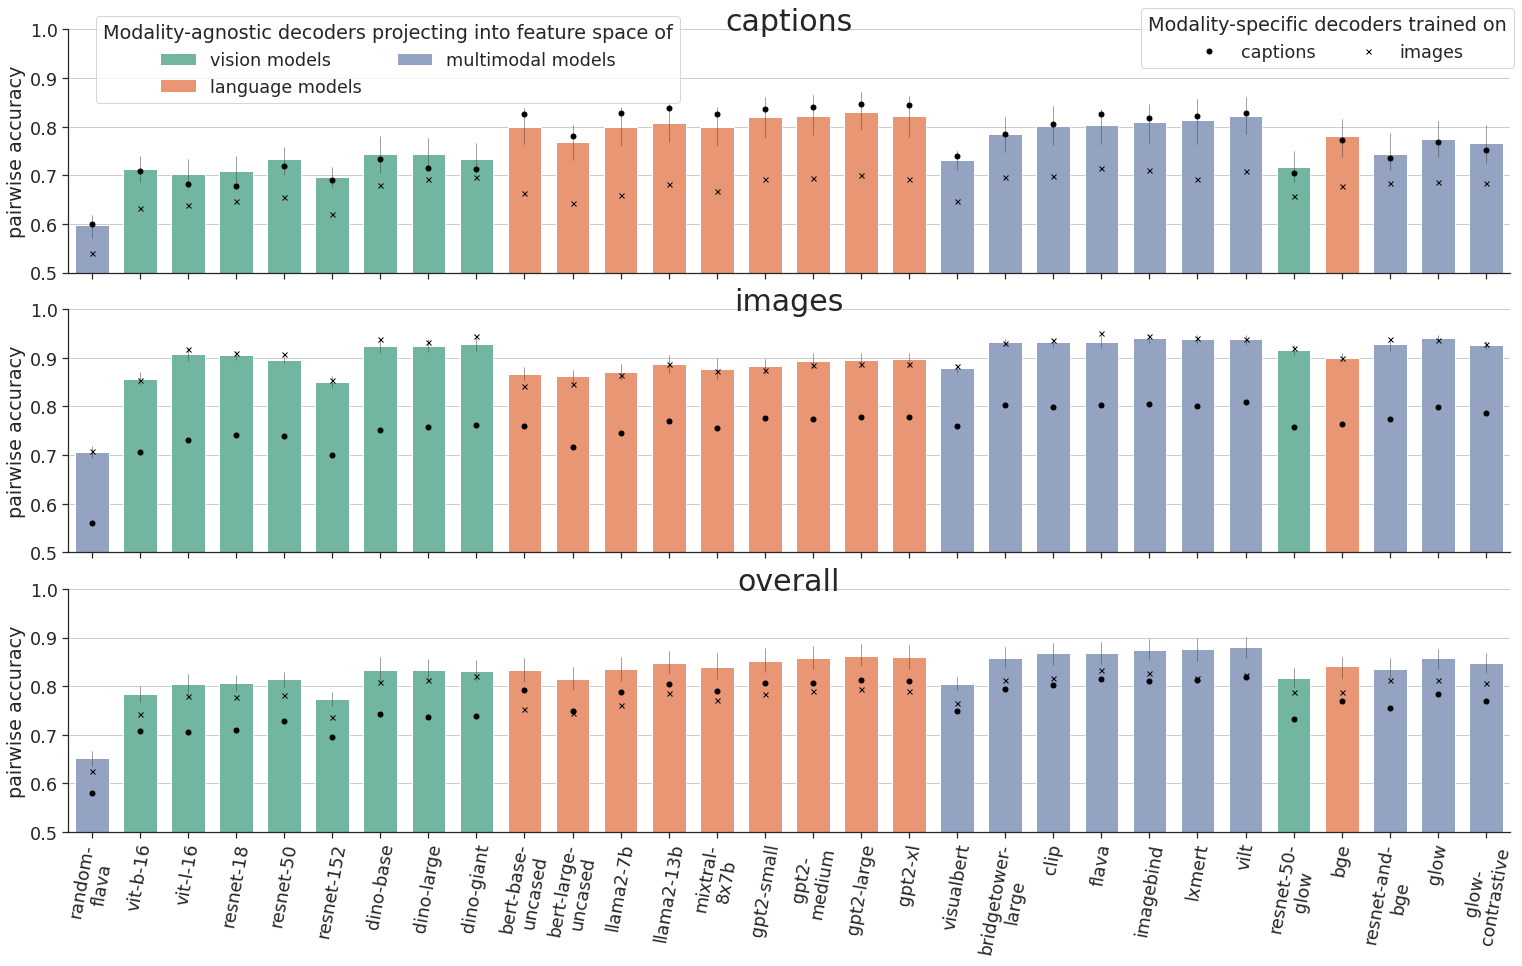

In [13]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "vision+lang": "multimodal models"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc_mean"]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
                             legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## V, L, or multimodal feats for multimodal models

<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

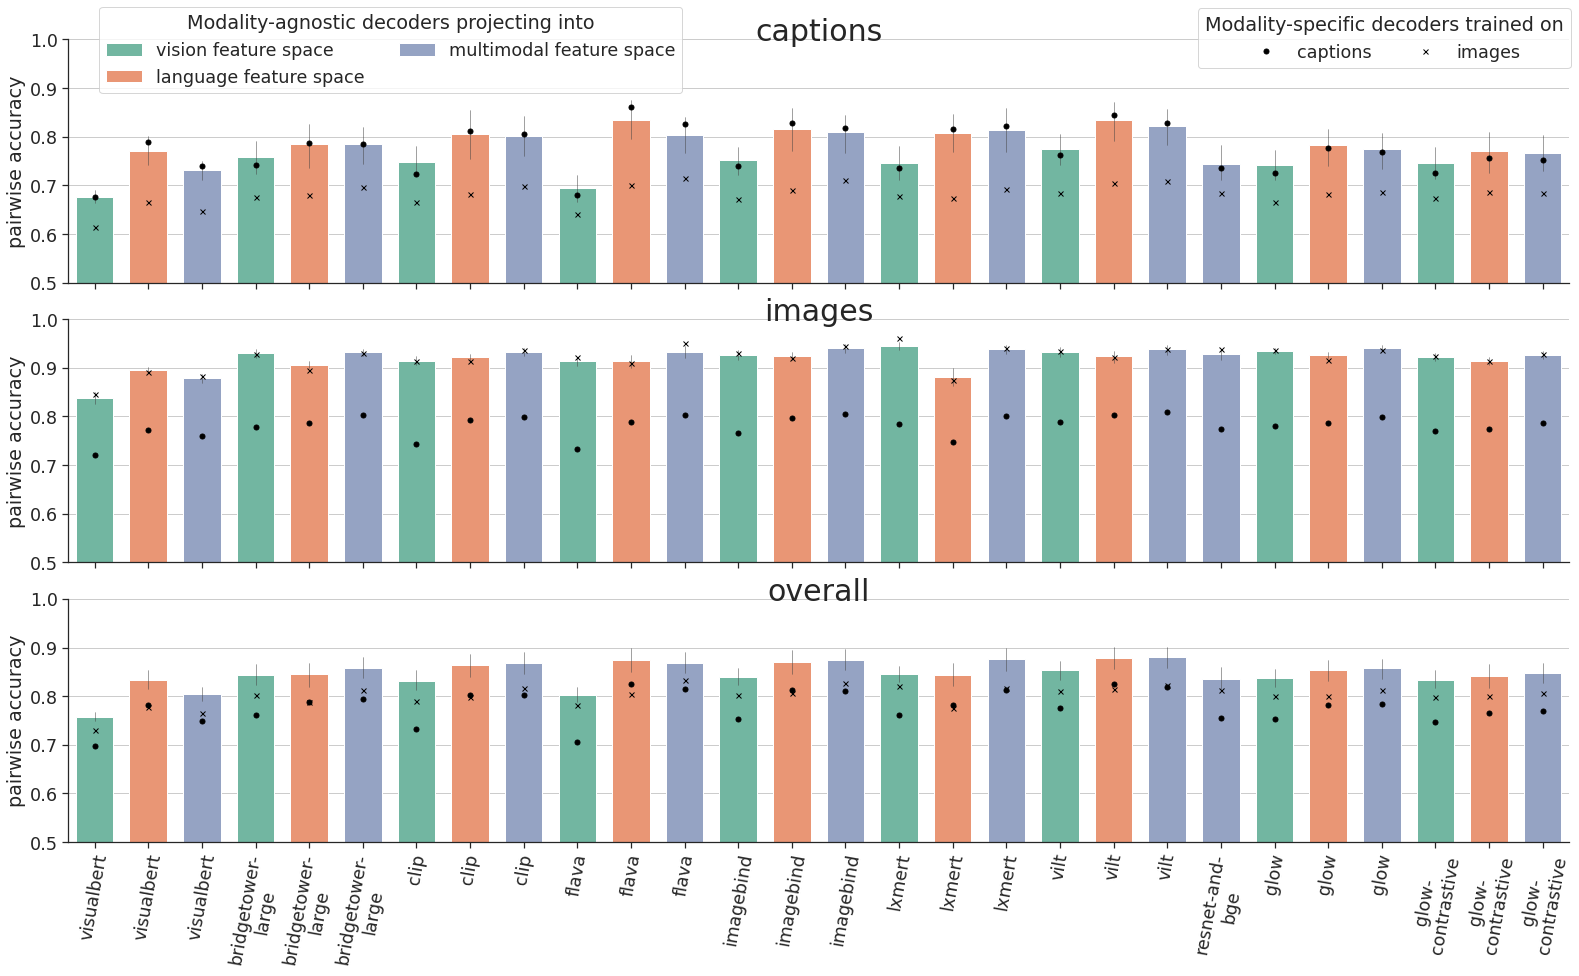

In [14]:
feat_order = ["vision feature space", "language feature space", "multimodal feature space"]

model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_vision+lang"]
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(model_feats_exluded)].copy()

data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]
data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision feature space", "lang": "language feature space", "vision+lang": "multimodal feature space"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc_mean"]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# Decoding with GloW

<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

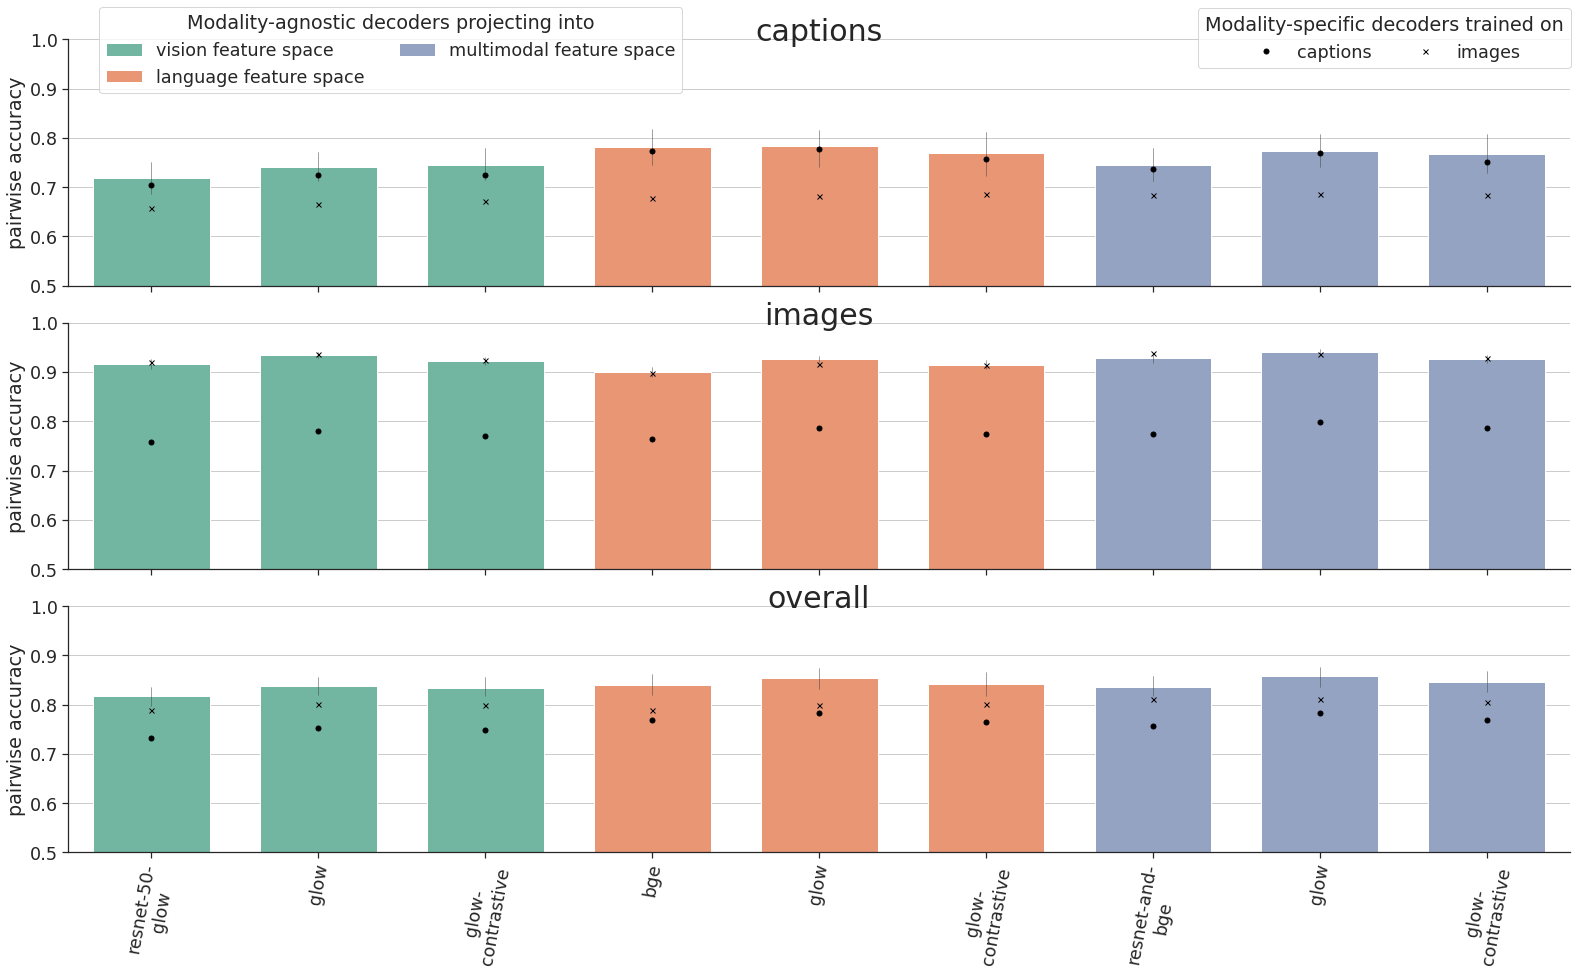

In [15]:
feat_order = ["vision feature space", "language feature space", "multimodal feature space"]

model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_vision+lang"]
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(model_feats_exluded)].copy()

# models_to_plot = ["resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]
model_feat_order = ['resnet-50-glow_vision', 'glow_vision', 'glow-contrastive_vision', 'bge_lang', 'glow_lang', 'glow-contrastive_lang', 'resnet-and-bge_vision+lang', 'glow_vision+lang', "glow-contrastive_vision+lang"]
data_to_plot = data_to_plot[data_to_plot.model_feat.isin(model_feat_order)]
data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision feature space", "lang": "language feature space", "vision+lang": "multimodal feature space"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
# model_feat_order = calc_model_feat_order(data_to_plot)
# model_feat_order = ['resnet-50-glow_vision', 'glow_vision', 'bge_lang', 'glow_lang', 'resnet-and-bge_vision+lang', 'glow_vision+lang']
metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc_mean"]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into")
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## CLS or mean feats for vision models

<ipython-input-9-047df2b0dedf>:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,
<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


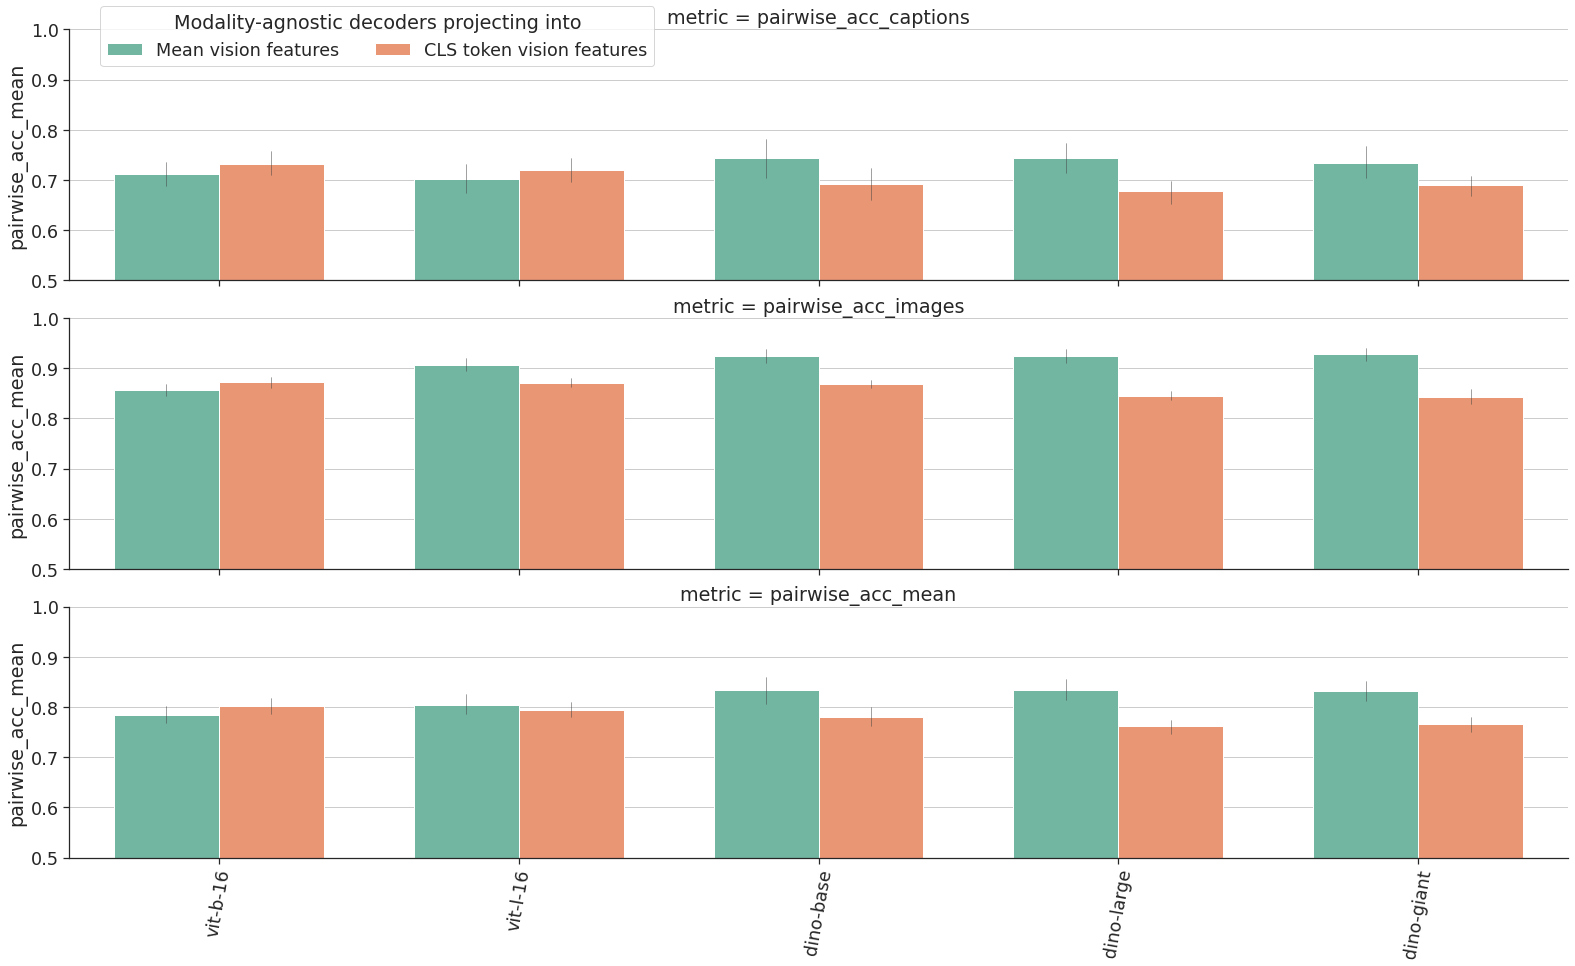

In [16]:
model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_vision+lang"]
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(model_feats_exluded)].copy()

vision_models_both_options = [m for m in vision_models if len(data_to_plot[data_to_plot.model == m].vision_features.unique()) == 2]
data_to_plot = data_to_plot[data_to_plot.model.isin(vision_models_both_options)]

vision_feat_order = ["Mean vision features", "CLS token vision features"]
data_to_plot["vision_features"] = data_to_plot.vision_features.replace({"visual_feature_mean": "Mean vision features", "visual_feature_cls": "CLS token vision features"})

data_to_plot = data_to_plot[data_to_plot.training_mode == "modality-agnostic"]

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc_mean"]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="vision_features", hue_order=vision_feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.0), height=4.5, legend_title="Modality-agnostic decoders projecting into", plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_vision_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## ROI-based decoding

<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

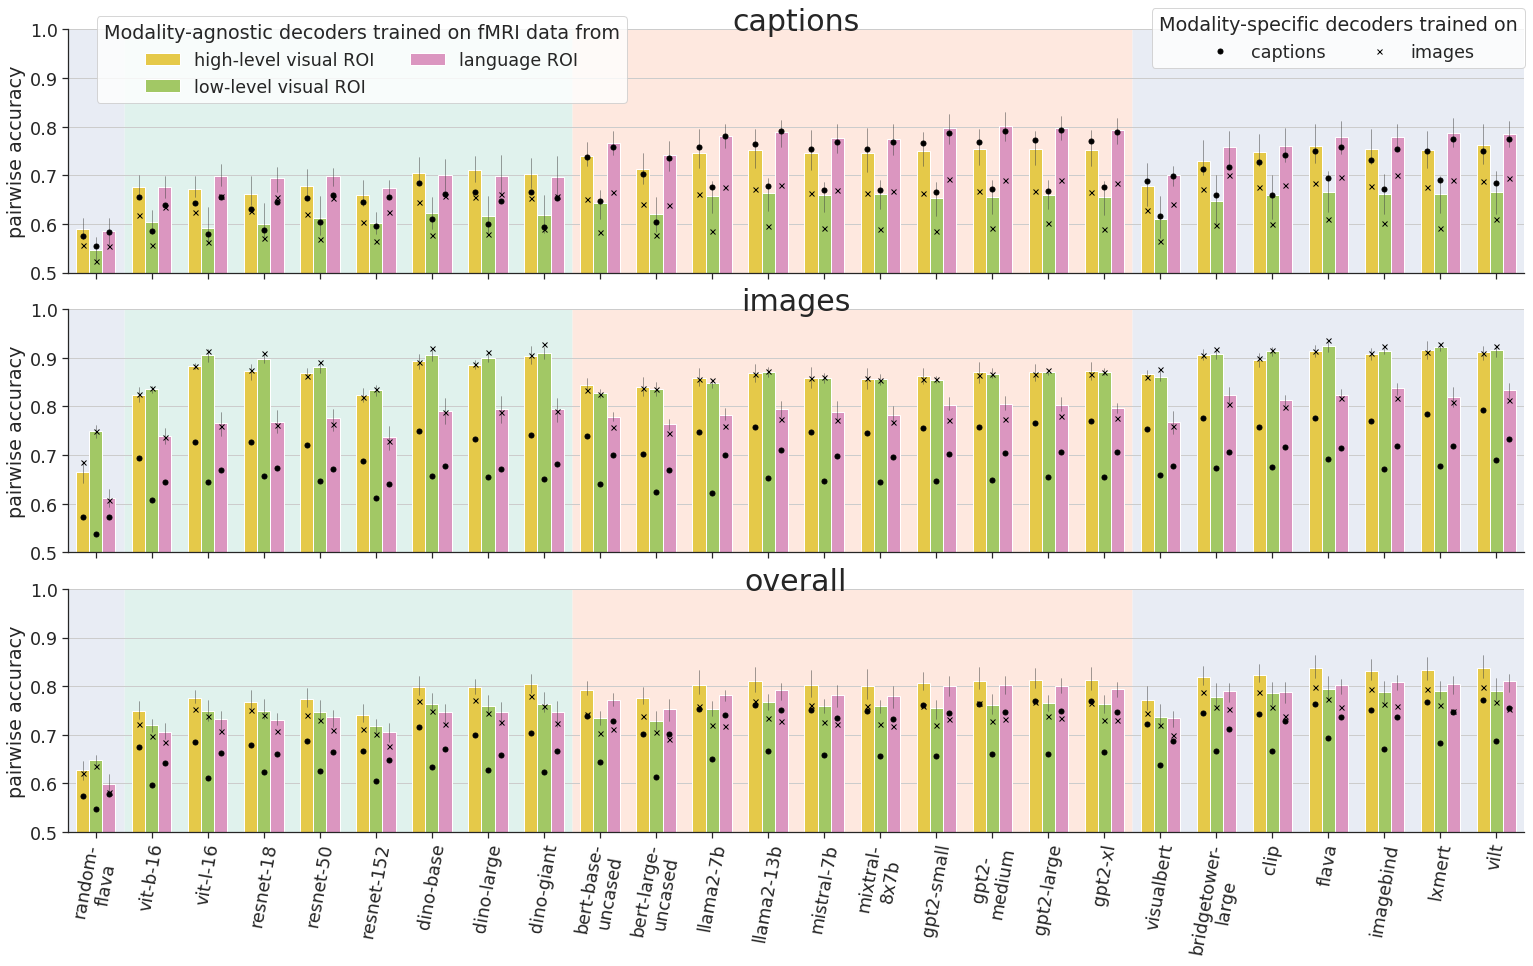

In [17]:
MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI"]
# MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI", "functional_Language", "functional_Visual1", "functional_Visual2", "functional_Default", "functional_Visual1_Visual2"]

MASK_PALETTE = sns.color_palette('Set2')[3:3+len(MASK_ORDER)][::-1]

# MODEL_FEATS_INCLUDED = ["resnet-50_vision", "dino-giant_vision", "gpt2-large_lang", "llama2-13b_lang", "flava_vision+lang"]
# data_all_masks = all_data_avg[all_data_avg.model_feat.isin(MODEL_FEATS_INCLUDED)].copy()

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_all_masks = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_all_masks = data_all_masks[data_all_masks.vision_features == 'visual_feature_mean']


data_all_masks["mask"] = data_all_masks["mask"].replace({"anatomical_visual_low_level": "low-level visual ROI", "anatomical_lang": "language ROI", "anatomical_visual_high_level": "high-level visual ROI"})

data_all_masks = data_all_masks[data_all_masks["mask"].isin(MASK_ORDER)].copy()

model_feat_order = calc_model_feat_order(data_all_masks)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc_mean"]

dodge = 0.47
# dodge = 0.6
figure, lgd = create_result_graph(data_all_masks, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0.5, 1),
                                  legend_title="Modality-agnostic decoders trained on fMRI data from", dodge=dodge, legend_bbox=(0.06,0.99))

colors_bg = sns.color_palette('Set2')[:3]
for i in range(len(figure.axes)):
    figure.axes[i, 0].axvspan(-0.5, 0.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(0.5, 8.5, facecolor=colors_bg[0], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(8.5, 18.5, facecolor=colors_bg[1], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(18.5, 25.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
plt.xlim((-0.5, 25.5))


# plt.subplots_adjust(top=0.98, bottom=0.05, hspace=0)
plt.savefig(os.path.join(RESULTS_DIR, f"roi_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [18]:
n_voxels_data = data_all_masks[~data_all_masks.num_voxels.isna()]
n_voxels_data = {mask: n_voxels_data[n_voxels_data["mask"] == mask].num_voxels.mean() for mask in n_voxels_data["mask"].unique()}
# n_voxels_data.update({
#     # "whole_brain": 214739,
#     "visual_high_level": 14698,
#     "visual_low_level": 13955
# })
print(n_voxels_data)
# sns.barplot(data=n_voxels_data)
# # plt.yscale("log")
# plt.xticks(rotation = 80)
# plt.ylabel("num voxels")
# plt.title("Number of voxels for each mask (whole brain: 214,739)")
# plt.tight_layout()
# plt.savefig(os.path.join(RESULTS_DIR, f"num_voxels.png"), dpi=300)

{'language ROI': 11178.833333333334, 'high-level visual ROI': 11387.833333333334, 'low-level visual ROI': 10578.166666666666}


## Per-subject results

In [19]:
FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-9-047df2b0dedf>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-f37793b7ed8d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, whic

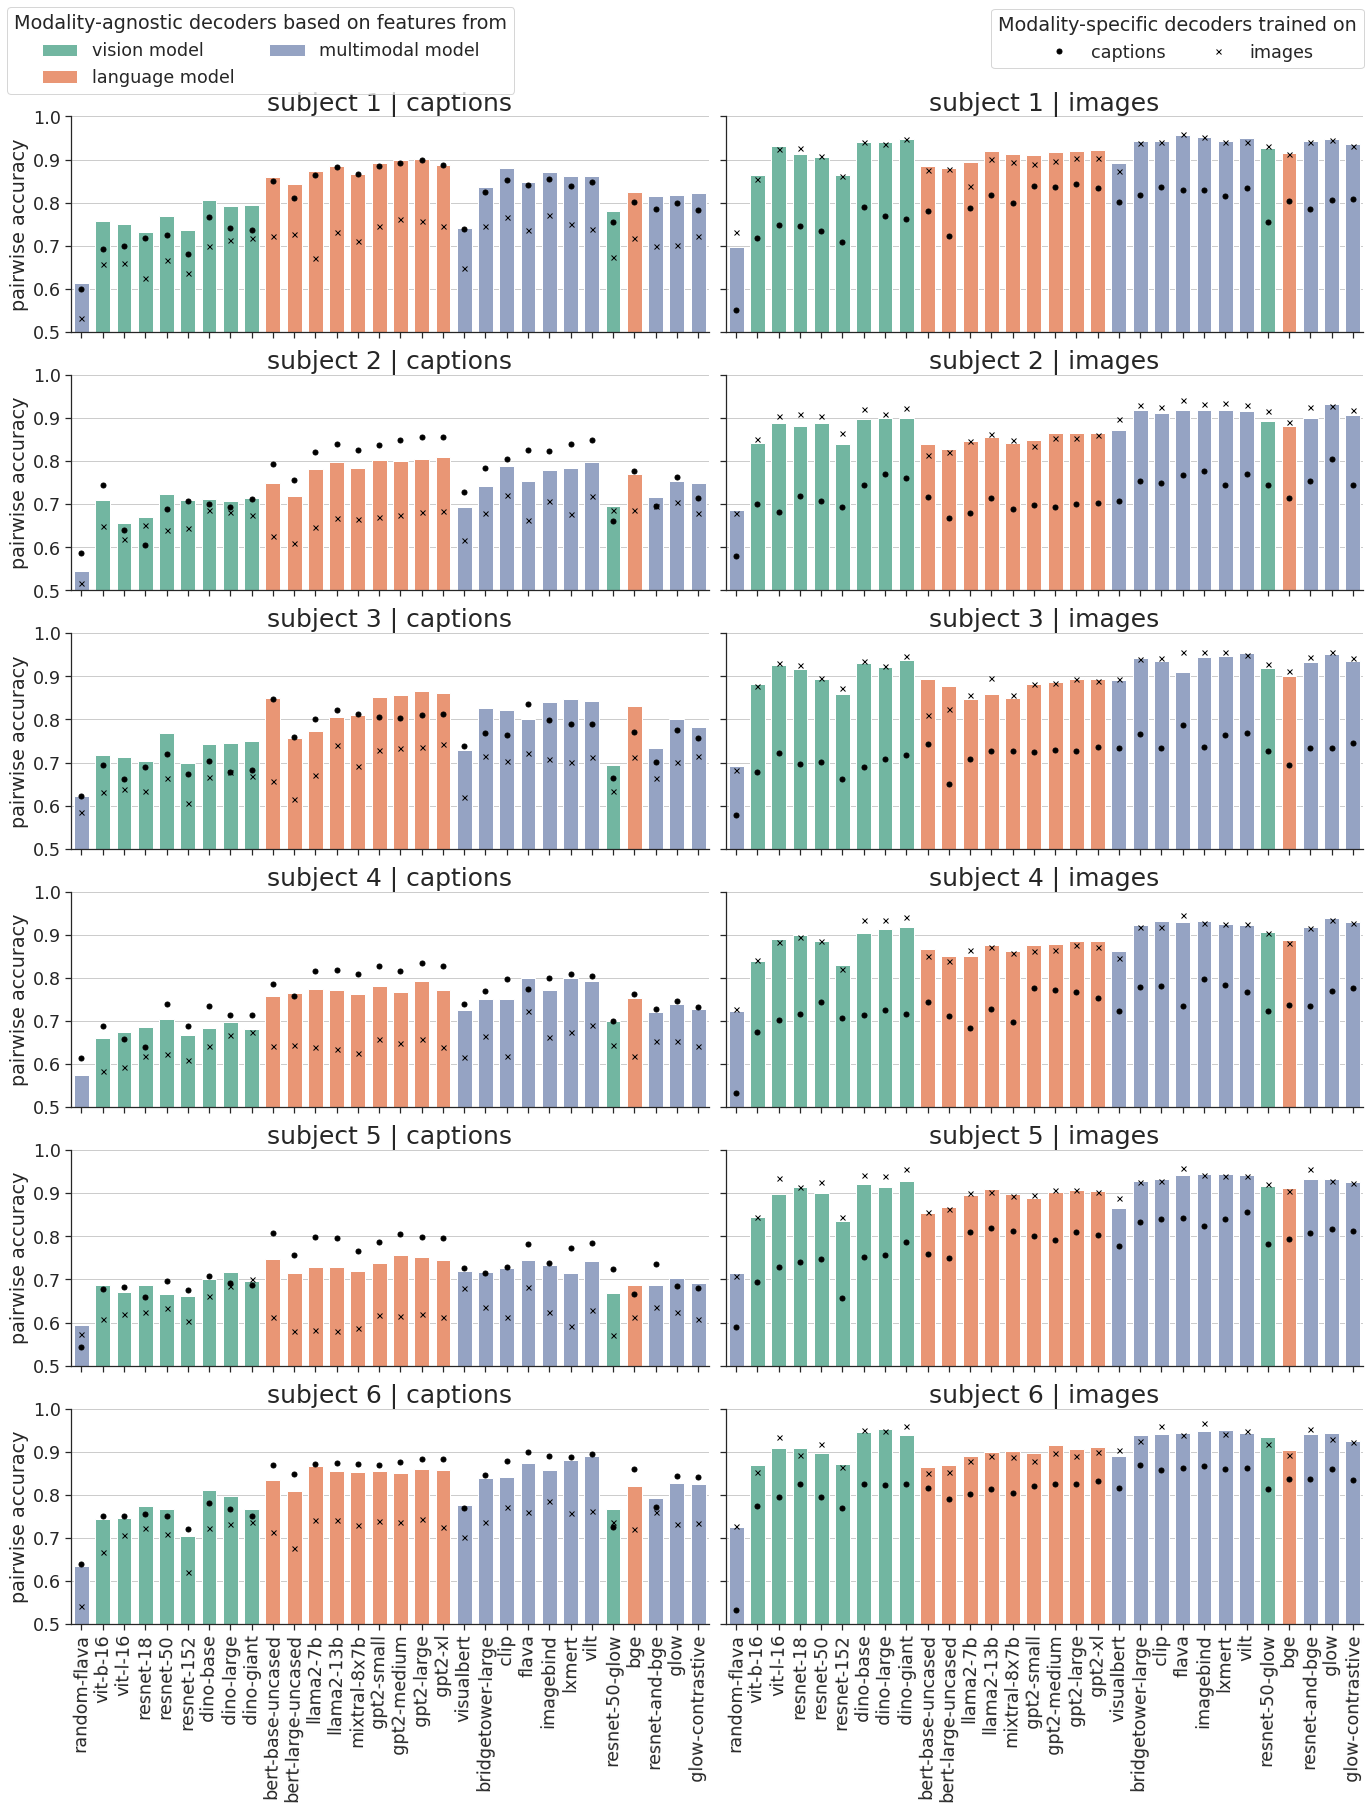

In [20]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision model", "language model", "multimodal model"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision model", "lang": "language model", "vision+lang": "multimodal model"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

## RSA noise ceiling

In [21]:
RSA_METRIC = "spearmanr"
RSA_MATRIX_METRIC = "spearmanr"
rsa_noise_ceilings_path = os.path.join(RSA_NOISE_CEILING_DIR, f"{RSA_METRIC}_{RSA_MATRIX_METRIC}.p")
rsa_noise_ceilings = pickle.load(open(rsa_noise_ceilings_path, 'rb'))
rsa_noise_ceiling_captions_mean = np.mean(list(rsa_noise_ceilings["rsa_captions"].values()))
rsa_noise_ceiling_images_mean = np.mean(list(rsa_noise_ceilings["rsa_images"].values()))

# rsa_noise_ceiling_std = np.std(list(rsa_noise_ceilings.values()))
print(rsa_noise_ceiling_captions_mean)
print(rsa_noise_ceiling_images_mean)

# print(rsa_noise_ceiling_std)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.7), palette=palette, hue_order=model_feat_order, noise_ceiling=rsa_noise_ceiling_mean)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.3), palette=palette, hue_order=model_feat_order)


0.016981539366333558
0.15442422589374546


In [22]:
all_data_no_mask = all_data[all_data["mask"] == "whole_brain"]
all_data_no_mask[(all_data_no_mask.subject == 'sub-03')].alpha

2763      10000.0
2764      10000.0
2765      10000.0
2766      10000.0
2767      10000.0
           ...   
17585    100000.0
17586    100000.0
17587    100000.0
17588    100000.0
17589    100000.0
Name: alpha, Length: 685, dtype: float64